In [57]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import shapely as shp

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

In [58]:
# read in LEHD OD data
lehd = pd.read_csv('data/lehd_od_2014.csv',
 dtype = {'w_geocode':'string',
          'h_geocode':'string'})

# keep only what we need
lehd = lehd[['w_geocode','h_geocode','S000']]
lehd.columns = ['w_geocode','h_geocode','people']

In [59]:
# read in nyc census block shapefiles
nycshp = gp.read_file('data/nycb2010_16c/nycb2010.shp')

# set up cooridnate system
nycshp = nycshp.to_crs(epsg=2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

# add state code 36 and leading digits for county code
nycshp['BCTCB2010'] = [i[1:] for i in nycshp['BCTCB2010']]
nycshp.BCTCB2010[nycshp.BoroName == 'Staten Island'] = '36085' + nycshp.BCTCB2010[nycshp.BoroName == 'Staten Island']
nycshp.BCTCB2010[nycshp.BoroName == 'Manhattan'] = '36061' + nycshp.BCTCB2010[nycshp.BoroName == 'Manhattan']
nycshp.BCTCB2010[nycshp.BoroName == 'Queens'] = '36081' + nycshp.BCTCB2010[nycshp.BoroName == 'Queens']
nycshp.BCTCB2010[nycshp.BoroName == 'Brooklyn'] = '36047' + nycshp.BCTCB2010[nycshp.BoroName == 'Brooklyn']
nycshp.BCTCB2010[nycshp.BoroName == 'Bronx'] = '36005' + nycshp.BCTCB2010[nycshp.BoroName == 'Bronx']

# we only need manhattan 
manshp = nycshp[nycshp.BoroName == 'Manhattan']

# keep only what we need
manshp = manshp[['BCTCB2010','geometry']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packag

In [60]:
# keep only LEHD with work and home both in NYC
lehd_all_nyc = lehd[np.in1d(lehd.h_geocode, nycshp.BCTCB2010) & np.in1d(lehd.w_geocode, nycshp.BCTCB2010)]
lehd_all_nyc.index = range(len(lehd_all_nyc))
lehd_all_nyc.head()

,w_geocode,h_geocode,people
0,360050002001002,360050002003011,1
1,360050002001002,360050090003000,1
2,360050002001002,360050090004000,1
3,360050002001002,360050090004003,1
4,360050002001004,360050090003000,1


In [61]:
# keep only LEHD with work and home both in manhattan
lehd = lehd[np.in1d(lehd.h_geocode, manshp.BCTCB2010) & np.in1d(lehd.w_geocode, manshp.BCTCB2010)]
lehd.index = range(len(lehd))
lehd.head()

,w_geocode,h_geocode,people
0,360610001001001,360610039001008,1
1,360610001001001,360610055022006,1
2,360610001001001,360610093002000,1
3,360610001001001,360610127002001,1
4,360610001001001,360610130004000,1


In [62]:
# find the distance between work and home
work = lehd.merge(manshp, how = 'left', left_on = 'w_geocode', right_on = 'BCTCB2010')
work = gp.GeoDataFrame(work, crs = manshp.crs, geometry = 'geometry')
home = lehd.merge(manshp, how = 'left', left_on = 'h_geocode', right_on = 'BCTCB2010')
home = gp.GeoDataFrame(home, crs = manshp.crs, geometry = 'geometry')

# note: distance is calculated in ft - convert to miles
lehd['distance'] = home.distance(work) / 5280

In [63]:
# find the distance between work and home for all NYC
work_all_nyc = lehd_all_nyc.merge(nycshp, how = 'left', left_on = 'w_geocode', right_on = 'BCTCB2010')
work_all_nyc = gp.GeoDataFrame(work_all_nyc, crs = nycshp.crs, geometry = 'geometry')
home_all_nyc = lehd_all_nyc.merge(nycshp, how = 'left', left_on = 'h_geocode', right_on = 'BCTCB2010')
home_all_nyc = gp.GeoDataFrame(home_all_nyc, crs = nycshp.crs, geometry = 'geometry')

# note: distance is calculated in ft - convert to miles
lehd_all_nyc['distance'] = home_all_nyc.distance(work_all_nyc) / 5280

In [64]:
# aggregate LEHD data to geocode level with weighted average distance to home and to work

def wavg(group):
    d = group['distance']
    w = group['people']
    return (d * w).sum() / w.sum()

lehd_work = pd.DataFrame(lehd.groupby('h_geocode', as_index = True).apply(wavg), columns = ['dist_towork'])
lehd_home = pd.DataFrame(lehd.groupby('w_geocode', as_index = True).apply(wavg), columns = ['dist_tohome'])
lehd_work_all_nyc = pd.DataFrame(lehd_all_nyc.groupby('h_geocode', as_index = True).apply(wavg), columns = ['dist_towork'])
lehd_home_all_nyc = pd.DataFrame(lehd_all_nyc.groupby('w_geocode', as_index = True).apply(wavg), columns = ['dist_tohome'])

In [65]:
lehd_all_nyc.head()

,w_geocode,h_geocode,people,distance
0,360050002001002,360050002003011,1,0.380520
1,360050002001002,360050090003000,1,0.757005
2,360050002001002,360050090004000,1,0.839670
3,360050002001002,360050090004003,1,0.780996
4,360050002001004,360050090003000,1,0.643882


In [66]:
lehd_pwork = pd.DataFrame(lehd[['w_geocode','people']].groupby('w_geocode', as_index = True).sum())
lehd_pwork.columns = ['workers']
lehd_plive = pd.DataFrame(lehd[['h_geocode','people']].groupby('h_geocode', as_index = True).sum())
lehd_plive.columns = ['residents']

In [67]:
lehd_pwork_all_nyc = pd.DataFrame(lehd_all_nyc[['w_geocode','people']].groupby('w_geocode', as_index = True).sum())
lehd_pwork_all_nyc.columns = ['workers']
lehd_plive_all_nyc = pd.DataFrame(lehd_all_nyc[['h_geocode','people']].groupby('h_geocode', as_index = True).sum())
lehd_plive_all_nyc.columns = ['residents']

In [68]:
dist = lehd_home.merge(lehd_work, left_index = True, right_index = True)
dist = dist.merge(lehd_pwork, left_index = True, right_index = True)
dist = dist.merge(lehd_plive, left_index = True, right_index = True)
dist.head()

,dist_tohome,dist_towork,workers,residents
360610001001001,6.260197,5.989905,7,74
360610002011000,2.055703,2.408299,26,248
360610002012000,2.813478,2.399098,18,288
360610002012001,2.754103,2.136880,38,122
360610002021001,3.675661,2.516509,12,66


In [69]:
dist_all_nyc = lehd_home_all_nyc.merge(lehd_work_all_nyc, left_index = True, right_index = True)
dist_all_nyc = dist_all_nyc.merge(lehd_pwork_all_nyc, left_index = True, right_index = True)
dist_all_nyc = dist_all_nyc.merge(lehd_plive_all_nyc, left_index = True, right_index = True)
dist_all_nyc.head()

,dist_tohome,dist_towork,workers,residents
360050002001002,0.689548,5.804126,4,58
360050002001004,2.688824,4.226865,5,18
360050002002002,0.812085,4.924776,6,60
360050002002003,3.260500,5.304640,4,53
360050002002010,1.957042,4.132824,3,15


In [70]:
# create and write a shapefile with census block and average commute distance
cb_dist = manshp.merge(dist, left_on = 'BCTCB2010', right_index = True)
#cb_dist.columns = ['cb','geometry','dist_tohome', 'dist_towork', 'workers']

cb_dist_all_nyc = nycshp.merge(dist_all_nyc, left_on = 'BCTCB2010', right_index = True)

if not os.path.exists('data/cb_dist/'):
    os.makedirs('data/cb_dist/')
    
cb_dist.to_file('data/cb_dist/cb_dist.shp')
cb_dist_all_nyc.to_file('data/cb_dist/cb_dist_all_nyc.shp')

cb_dist_all_nyc.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry,dist_tohome,dist_towork,workers,residents
1,360850020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391613 161835.2652098391,...",1.703449,7.612329,3,24
2,360850027001000,5,Staten Island,1000,002700,150406.784296,1703.381058,"POLYGON ((963363.116638183 167356.3334471463, ...",7.967243,6.621446,8,60
3,360850040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((960069.9965820312 161953.6936156093,...",9.394226,6.893567,3,17
5,360850074001000,5,Staten Island,1000,007400,139084.016712,1540.875503,"POLYGON ((965950.5722045903 156723.1070067168,...",3.659894,5.956579,2,30
8,360850112011000,5,Staten Island,1000,011201,196112.284882,1943.029020,"POLYGON ((960211.8796386705 151958.16602771, 9...",5.830894,5.991521,55,19


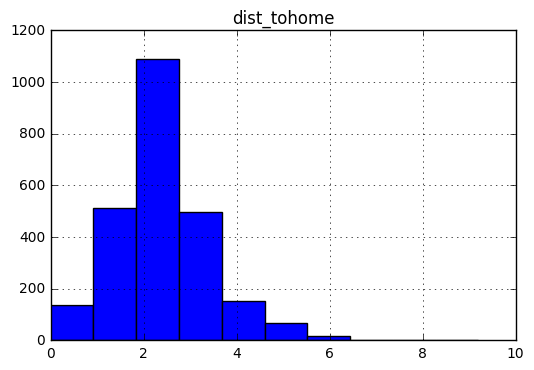

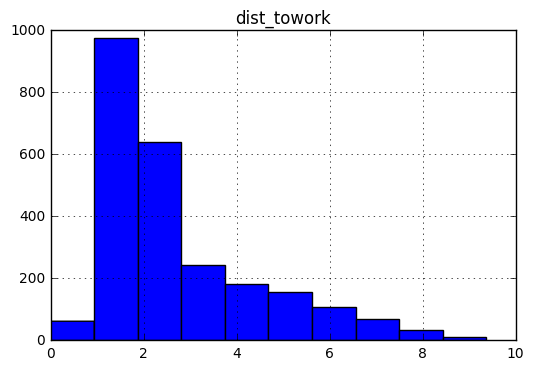

In [71]:
import pylab as pl
cb_dist.hist('dist_tohome')
cb_dist.hist('dist_towork')
pl.show()

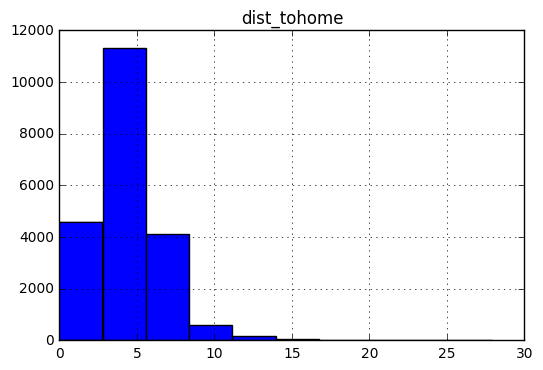

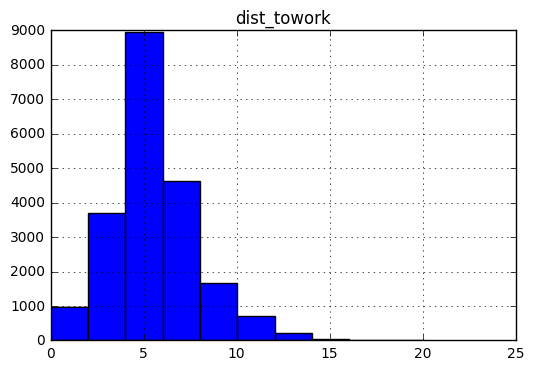

In [72]:
cb_dist_all_nyc.hist('dist_tohome')
cb_dist_all_nyc.hist('dist_towork')
pl.show()